# Are MANRS ASes conformant to Action 4?
MANRS action 4 states that MANRS networks should originate prefixes that are RPKI or IRR valid.

Paper: https://www.caida.org/catalog/papers/2022_mind_your_manrs/mind_your_manrs.pdf

In [1]:
import pandas as pd
import os
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import requests
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import bz2
import lz4.frame
import urllib
import gzip

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# MANRS ASes

Parse ASes in the MANRS Network Operators Program. CSV files can be downloaded from:  
https://www.manrs.org/netops/participants/

In [3]:
manrs = []
manrs_org = {}
manrs_org2as = defaultdict(list)
with open('manrs_isps.csv', 'rt') as f:  #replace with new file
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[2].split(';')
        for i in asns:
            try:
                manrs.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

Parse ASes in the MANRS CDN and Cloud Provider Program. CSV files can be downloaded from:  
https://www.manrs.org/cdn-cloud-providers/participants/

In [4]:
manrscdn = []
with open('manrs_cdns.csv', 'rt') as f:   #replace with new file
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[1].split(';')
        for i in asns:
            if not i.isdigit():
                continue
            try:
                manrscdn.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

In [5]:
manrscdn

[20940,
 52580,
 59414,
 266444,
 50520,
 135337,
 54825,
 8280,
 14061,
 32934,
 8075,
 8074,
 2906,
 40027,
 55095,
 13335,
 16509,
 133800,
 15169,
 7342,
 20473]

In [6]:
manrsas = manrs + manrscdn

In [7]:
len(manrs)

849

In [8]:
len(manrscdn)

21

## Group by AS size (number of customers)  

### Parse CAIDA AS Relationship Dataset

CAIDA AS Relationship Dataset can be downloaded from:  
https://www.caida.org/catalog/datasets/as-relationships/  
Use files with the extension `.as-rel.txt.bz2`

In [9]:
path = '20220301.as-rel.txt.bz2'   #replace with new file
as_cust = defaultdict(int)
with bz2.open(path, 'rt') as file:
    for line in file:
        if line.startswith('#'):
            continue
        data = line.strip().split('|')
        AS1 = int(data[0])
        AS2 = int(data[1])
        rel = data[2]
        if rel == '1':
            as_cust[AS2] += 1
        elif rel == '-1':
            as_cust[AS1] += 1

In [10]:
cust_deg = pd.DataFrame(as_cust.items(), columns=['asn', 'cust'])

In [11]:
small = cust_deg[cust_deg.cust <= 2]['asn']
medium = cust_deg[(cust_deg.cust > 2) & (cust_deg.cust < 180)]['asn']
large = cust_deg[cust_deg.cust >= 180]['asn']

In [12]:
cust_deg

,asn,cust
0,1,2
1,2,2
2,4,1
3,5,2
4,6,1
...,...,...
11412,399888,1
11413,399895,1
11414,399998,1
11415,400282,1


### separate MANRS and non-MANRS ASes into small, medium, and large catgories

small ASes have # of customers < 2  
medium ASes have # of customers between 2 and 180  
Large ASes have # of customers > 180

In [13]:
medium_manrs = set(manrsas).intersection(set(medium))
large_manrs = set(manrsas).intersection(set(large))
small_manrs = set(manrsas) - medium_manrs - large_manrs

In [14]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

520 319 24


In [15]:
small_non_manrs = set(small) - small_manrs
medium_non_manrs = set(medium) - medium_manrs
large_non_manrs = set(large) - large_manrs

# RPKI and IRR statuses of prefixes originated by MANRS and non-MANRS networks

## Process data from the Internet Health Report
IHR data can be downloaded from:  
https://ihr-archive.iijlab.net/ihr/rov/  

IHR also provides a dashboard:  
https://ihr.iijlab.net/ihr/en-us/rov

In [16]:
ihrurl = 'https://ihr-archive.iijlab.net/ihr/rov/2022/05/01/ihr_rov_2022-05-01.csv.lz4' #replace with new file

In [17]:
def process_ihr(url):
    try:
        handle = urllib.request.urlopen(url)
    except:
        print('URL not found', url)
        raise Exception
        return
    with lz4.frame.open(handle) as f:
        df = pd.read_csv(f)
        origindf = df[df.asn_id == df.originasn_id]
        return origindf

In [18]:
origindf = process_ihr(ihrurl)

In [19]:
origindf = origindf[origindf.af == 4]

## Explanation of column names
`prefix`: IP prefix observed in BGP, announced by the AS denoted in `originasn_id`  
`hege`: AS hegemony value, not used in conformance analysis. Ignore column.  
`visibility`: visibility of the prefix in RouteViews and RIPE RIS collectors, not used in conformance analysis. Ignore column.  
`moas`: Whether the `prefix` is announced by multiple origin ASes. `t` for True and `f` for False. Ignore Column.  
`originasn_id`: the AS announcing the `prefix`  
`asn_id`: same as `originasn_id`  

In [20]:
origindf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
691982,1415697055,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691984,1415697053,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691986,1415697051,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691988,1415697049,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
691990,1415697047,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,397224,US,397224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294722,1411094442,2022-05-01 00:00:00+00,1.6.73.0/24,1.000000,4,99.453552,Valid,Valid,assigned,assigned,Sify IP address space,f,9583,IN,9583
5294723,1411094441,2022-05-01 00:00:00+00,1.32.0.0/19,1.000000,4,98.907104,Valid,Valid,assigned,assigned,Telekom Malaysia Berhad\nCore IP & NGN\n17th F...,f,4788,MY,4788
5294724,1411094440,2022-05-01 00:00:00+00,1.72.0.0/23,1.000000,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,9605,JP,9605
5294725,1411094439,2022-05-01 00:00:00+00,1.66.90.0/24,1.000000,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,9605,JP,9605


In [21]:
manrs_origin = origindf[origindf.originasn_id.isin(manrsas)]
non_manrs_origin = origindf[~origindf.originasn_id.isin(manrsas)]

In [22]:
manrs_origin['nettype'] = manrs_origin['originasn_id'].apply(lambda x: 'CDN' if x in manrscdn else 'ISP')

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [23]:
small_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(small)]
medium_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(medium)]
large_manrs_origin = manrs_origin[manrs_origin.originasn_id.isin(large)]

In [24]:
small_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(small)]
medium_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(medium)]
large_non_manrs_origin = non_manrs_origin[non_manrs_origin.originasn_id.isin(large)]

## RPKI: Check if announced prefixes are RPKI valid

In [25]:
manrs_origin_rpki = manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
manrs_origin_rpki['rpki_percent'] = (1-manrs_origin_rpki['NotFound']/manrs_origin_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [26]:
non_manrs_origin_rpki = non_manrs_origin.groupby(['originasn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
non_manrs_origin_rpki['rpki_percent'] = (1-non_manrs_origin_rpki['NotFound']/non_manrs_origin_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [27]:
small_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(small)]
medium_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(medium)]
large_manrs_origin_rpki = manrs_origin_rpki[manrs_origin_rpki.originasn_id.isin(large)]

In [28]:
small_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(small)]
medium_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(medium)]
large_non_manrs_origin_rpki = non_manrs_origin_rpki[non_manrs_origin_rpki.originasn_id.isin(large)]

### Are MANRS ASes more likely to originate RPKI valid prefixes than non_MANRS ASes?

The code snippet corresponds to figure 5(a) in the paper

In [29]:
manrs_origin_rpki['valid_percent'] = (manrs_origin_rpki['Valid']/manrs_origin_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100
non_manrs_origin_rpki['valid_percent'] = (non_manrs_origin_rpki['Valid']/non_manrs_origin_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100


In [30]:
small_manrs_origin_rpki['valid_percent'] = (small_manrs_origin_rpki['Valid']/small_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
small_non_manrs_origin_rpki['valid_percent'] = (small_non_manrs_origin_rpki['Valid']/small_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

medium_manrs_origin_rpki['valid_percent'] = (medium_manrs_origin_rpki['Valid']/medium_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
medium_non_manrs_origin_rpki['valid_percent'] = (medium_non_manrs_origin_rpki['Valid']/medium_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

large_manrs_origin_rpki['valid_percent'] = (large_manrs_origin_rpki['Valid']/large_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
large_non_manrs_origin_rpki['valid_percent'] = (large_non_manrs_origin_rpki['Valid']/large_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100



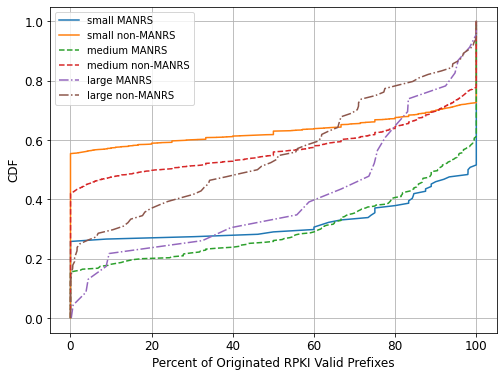

In [31]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_manrs_origin_rpki)), label='small MANRS', linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_rpki)), label='small non-MANRS', linestyle='-')
plt.plot(np.sort(medium_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_rpki)), label='medium MANRS', linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_rpki)), label='medium non-MANRS', linestyle='--')
plt.plot(np.sort(large_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_manrs_origin_rpki)), label='large MANRS', linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_rpki['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_rpki)), label='large non-MANRS', linestyle='-.')
plt.xlabel('Percent of Originated RPKI Valid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(80, 105)
plt.legend(loc=2)
plt.grid()

### Spot check: which ASes originated no RPKI valid prefixes? 

#### Parse CAIDA as2org dataset
CAIDA as2org dataset can be downloaded from: 
https://www.caida.org/catalog/datasets/as-organizations/

The code below maps AS numbers to organization names

In [32]:
path = '20220401.as-org2info.txt.gz'   #replace with new file
mapping = {}
companyname = {}
org2as = defaultdict(list)

with gzip.open(path, 'rt') as as2org:
    for line in as2org:
        l = line.strip('\n').split('|')
        asn = None
        if l[0].isdigit():
            asn = l[0]
            mapping[int(asn)] = l[3]
        elif len(l) == 5:
            companyname[l[0]] = (l[2], l[3])
    for i in mapping:
        orgname = companyname[mapping[i]]
        mapping[i] = orgname
        org2as[orgname].append(i)

In [33]:
large_non_manrs_origin_rpki['company'] = large_non_manrs_origin_rpki['originasn_id'].apply(lambda x: mapping[x] if x in mapping else None)


/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


#### **Only non-MANRS ASes originate no RPKI valid prefixes**

In [34]:
large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.valid_percent == 0]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,company
235,577,0,0,675,0,0.000000,0.0,"(Bell Canada, CA)"
917,2828,0,0,112,0,0.000000,0.0,"(Verizon Business, US)"
1028,3216,0,0,788,0,0.000000,0.0,"(PJSC ""Vimpelcom"", RU)"
1054,3255,0,0,316,0,0.000000,0.0,(State Enterprise Scientific and Telecommunica...
2764,8167,0,0,340,0,0.000000,0.0,"(BRASIL TELECOM COMUNICACAO MULTIMIDIA S.A, BR)"
3422,9318,0,0,643,0,0.000000,0.0,"(SK Broadband Co Ltd, KR)"
11947,23106,0,0,31,0,0.000000,0.0,(AMERICAN TOWER DO BRASIL-COMUNICAÇÂO MULTIMÍD...
12492,23947,2,0,9,0,18.181818,0.0,"(PT.Mora Telematika Indonesia, ID)"
15696,29076,0,0,56,0,0.000000,0.0,"(Filanco LLC, RU)"
15791,29226,0,0,17,0,0.000000,0.0,"(JSC Mastertel, RU)"


In [35]:
large_non_manrs_origin_rpki[large_non_manrs_origin_rpki.valid_percent == 100]

rpki_status,originasn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,valid_percent,company
10411,20764,0,0,0,5,100.0,100.0,"(CJSC RASCOM, RU)"
30285,50607,0,0,0,2,100.0,100.0,"(Stowarzyszenie e-Poludnie, PL)"
36101,58717,0,0,0,32,100.0,100.0,"(Summit Communication Limited, BD)"
38362,62081,0,0,0,1,100.0,100.0,"(Stowarzyszenie e-Poludnie, PL)"
50345,201054,0,0,0,1,100.0,100.0,"(Stowarzyszenie e-Poludnie, PL)"


In [36]:
large_manrs_origin_rpki['totalPO'] = large_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1)
large_non_manrs_origin_rpki['totalPO'] = large_non_manrs_origin_rpki[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1)

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### How many RPKI valids, invalids do each type of networks originate?

#### medium MANRS networks that originated RPKI invalid prefixes

In [37]:
med_invalid_ASN = medium_manrs_origin_rpki[medium_manrs_origin_rpki.Invalid > 0]['originasn_id']
for i in med_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

4181 TDS Telecom
7725 Comcast
12735 TurkNet Iletisim Hizmetleri A.S.
16509 Amazon Web Services
20940 Akamai Technologies
21700 Neptune Networks
23688 Link3 Technologies Ltd.
33287 Comcast
33659 Comcast
33662 Comcast
33667 Comcast
33668 Comcast
47787 EDGOO NETWORKS LDA
59414 cloudscale.ch


In [38]:
manrs_origin[manrs_origin.originasn_id.isin(med_invalid_ASN) & (manrs_origin.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
705730,1415683351,2022-05-01 00:00:00+00,200.60.190.0/24,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,Proxy-registered route object,f,20940,PE,20940,CDN
705744,1415683337,2022-05-01 00:00:00+00,200.60.136.0/23,0.360544,4,36.065574,Invalid,Invalid,assigned,assigned,UniRed - Infointernet - RED_36\nTelefonica Dat...,f,20940,PE,20940,CDN
1218161,1415170828,2022-05-01 00:00:00+00,50.207.86.0/24,1.000000,4,95.628415,Invalid,Invalid,assigned,assigned,"Comcast Cable Communications, Inc.\n1800 Bisho...",f,33667,US,33667,ISP
1539864,1414849266,2022-05-01 00:00:00+00,130.156.192.0/20,0.346939,4,34.972678,Invalid,Invalid,assigned,assigned,"NJEDge.Net INC\n625 Broad Street, Suite 260\nN...",f,33659,US,33659,ISP
1587056,1414802083,2022-05-01 00:00:00+00,159.148.130.0/24,1.000000,4,98.907104,Invalid,Invalid,assigned,assigned,LATNET,f,21700,LV,21700,ISP
1968948,1414420163,2022-05-01 00:00:00+00,103.9.104.0/24,0.639456,4,50.819672,Invalid,Invalid,assigned,assigned,route object for 103.9.104.0/24,f,23688,BD,23688,ISP
2120580,1414267989,2022-05-01 00:00:00+00,103.9.104.0/23,0.639456,4,50.819672,Invalid,Invalid,assigned,assigned,route object for 103.9.104.0/23,f,23688,BD,23688,ISP
2443586,1413945169,2022-05-01 00:00:00+00,50.229.207.0/24,1.000000,4,97.267760,Invalid,Invalid,assigned,assigned,"Comcast Cable Communications, Inc.\n1800 Bisho...",f,33287,US,33287,ISP
2722588,1413666921,2022-05-01 00:00:00+00,159.148.158.0/24,1.000000,4,98.907104,Invalid,Invalid,assigned,assigned,LATNET,f,21700,LV,21700,ISP
2722592,1413666917,2022-05-01 00:00:00+00,159.148.128.0/24,1.000000,4,98.907104,Invalid,Invalid,assigned,assigned,NaN,f,21700,LV,21700,ISP


#### medium MANRS networks that originated RPKI Invalid Prefix Length prefixes

In [39]:
med_invalid_len = medium_manrs_origin_rpki[medium_manrs_origin_rpki['Invalid,more-specific'] > 0]['originasn_id']
for i in med_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

7843 Charter Communications
7922 Comcast
8075 Microsoft
23674 Nayatel Pvt. Ltd
28294 Univox
33363 Charter Communications
48362 Stadtwerke Feldkirch


In [40]:
manrs_origin[manrs_origin.originasn_id.isin(med_invalid_len) & (manrs_origin.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
718348,1415670555,2022-05-01 00:00:00+00,92.249.22.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,NaN,f,48362,AT,48362,ISP
1526355,1414862791,2022-05-01 00:00:00+00,101.50.84.0/22,0.387755,4,36.612022,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Nayatel Route Object 101.50.64.0/18,f,23674,PK,23674,ISP
1549420,1414839426,2022-05-01 00:00:00+00,179.107.208.0/21,0.435374,4,40.983607,"Invalid,more-specific",Valid,assigned,assigned,Univox,f,28294,BR,28294,ISP
1963005,1414426153,2022-05-01 00:00:00+00,92.249.20.0/24,0.034014,4,11.475410,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,NaN,f,48362,AT,48362,ISP
3983079,1412405880,2022-05-01 00:00:00+00,68.207.192.0/19,1.000000,4,99.453552,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,RR-Route,f,33363,US,33363,ISP
4021161,1412368244,2022-05-01 00:00:00+00,68.207.160.0/20,1.000000,4,98.907104,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,RR-Route,f,33363,US,33363,ISP
4375107,1412014402,2022-05-01 00:00:00+00,50.221.163.0/24,1.000000,4,99.453552,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Comcast Cable Communications, Inc.\n1800 Bisho...",f,7922,US,7922,ISP
4446146,1411942869,2022-05-01 00:00:00+00,20.136.0.0/17,1.000000,4,98.360656,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Microsoft,f,8075,US,8075,CDN
4731809,1411657216,2022-05-01 00:00:00+00,50.221.162.0/24,1.000000,4,99.453552,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Comcast Cable Communications, Inc.\n1800 Bisho...",f,7922,US,7922,ISP
5255123,1411133970,2022-05-01 00:00:00+00,131.150.38.0/24,1.000000,4,98.360656,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,RR-TBONE,f,7843,US,7843,ISP


#### large MANRS networks that originated RPKI Invalid prefixes

In [41]:
large_invalid_ASN = large_manrs_origin_rpki[large_manrs_origin_rpki.Invalid > 0]['originasn_id']
for i in large_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

174 Cogent Communications Inc.
3356 CenturyLink
5511 Orange - Open Transit Internet
13335 Cloudflare
20115 Charter Communications
20473 Vultr
53062 GGNET TELECOM


In [42]:
manrs_origin[manrs_origin.originasn_id.isin(large_invalid_ASN) & (manrs_origin.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
699120,1415689926,2022-05-01 00:00:00+00,178.171.100.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,GB,174,ISP
1545909,1414843588,2022-05-01 00:00:00+00,45.84.242.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,US,174,ISP
1557276,1414831811,2022-05-01 00:00:00+00,216.173.83.0/24,0.061224,4,14.207650,Invalid,Invalid,assigned,assigned,H4Y Technologies LLC,t,174,US,174,ISP
2114870,1414274639,2022-05-01 00:00:00+00,98.154.77.0/24,0.006803,4,8.743169,Invalid,Invalid,assigned,assigned,RR-Route,t,20115,US,20115,ISP
2121627,1414268231,2022-05-01 00:00:00+00,85.239.55.0/24,0.700680,4,56.830601,Invalid,"Invalid,more-specific",assigned,assigned,NaN,f,174,RU,174,ISP
2121642,1414268216,2022-05-01 00:00:00+00,45.84.243.0/24,0.632653,4,51.366120,Invalid,Invalid,assigned,assigned,NaN,f,174,US,174,ISP
2788378,1413600735,2022-05-01 00:00:00+00,81.52.168.0/24,1.000000,4,98.907104,Invalid,Invalid,assigned,assigned,DZ,f,5511,FR,5511,ISP
2788386,1413600727,2022-05-01 00:00:00+00,81.52.167.0/24,1.000000,4,98.907104,Invalid,Invalid,assigned,assigned,DZ,f,5511,FR,5511,ISP
2852917,1413536054,2022-05-01 00:00:00+00,45.235.18.0/24,1.000000,4,99.453552,Invalid,Valid,assigned,assigned,GEGNET,f,53062,BR,53062,ISP
3201517,1413187992,2022-05-01 00:00:00+00,193.163.89.0/24,1.000000,4,99.453552,Invalid,Invalid,assigned,assigned,NaN,f,174,RU,174,ISP


In [43]:
large_invalid_len = large_manrs_origin_rpki[large_manrs_origin_rpki['Invalid,more-specific'] > 0]['originasn_id']
for i in large_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

8220 Colt Technology Services
13335 Cloudflare
20115 Charter Communications


In [44]:
manrs_origin[manrs_origin.originasn_id.isin(large_invalid_len) & (manrs_origin.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,nettype
860103,1415528778,2022-05-01 00:00:00+00,172.68.46.0/24,1.000000,4,99.453552,"Invalid,more-specific",Valid,assigned,assigned,"101 Townsend Street, San Francisco, California...",f,13335,US,13335,CDN
1963043,1414426058,2022-05-01 00:00:00+00,172.68.83.0/24,0.129252,4,18.579235,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"101 Townsend Street, San Francisco, California...",f,13335,US,13335,CDN
4154065,1412235444,2022-05-01 00:00:00+00,194.223.140.0/22,1.000000,4,96.721311,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,COLT ASIA,f,8220,JP,8220,ISP
4154068,1412235441,2022-05-01 00:00:00+00,194.223.136.0/22,1.000000,4,98.907104,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,COLT ASIA,f,8220,SG,8220,ISP
4288783,1412100726,2022-05-01 00:00:00+00,68.191.206.0/24,1.000000,4,98.360656,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Charter Aggregate,f,20115,US,20115,ISP
4481847,1411907149,2022-05-01 00:00:00+00,194.223.144.0/20,1.000000,4,97.267760,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,COLT ASIA,f,8220,JP,8220,ISP
4484677,1411904317,2022-05-01 00:00:00+00,141.101.90.0/24,1.000000,4,98.907104,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,NaN,f,13335,US,13335,CDN
4654139,1411734427,2022-05-01 00:00:00+00,193.82.32.0/19,1.000000,4,99.453552,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,GB-COLT,f,8220,SG,8220,ISP
4908338,1411480661,2022-05-01 00:00:00+00,194.223.128.0/21,1.000000,4,99.453552,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,COLT ASIA,f,8220,SG,8220,ISP
4991381,1411397723,2022-05-01 00:00:00+00,193.82.0.0/19,1.000000,4,97.267760,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,GB-COLT,f,8220,JP,8220,ISP


## IRR: Check if announced prefixes are IRR valid

In [45]:
manrs_origin_irr = manrs_origin.groupby(['originasn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
manrs_origin_irr['irr_percent'] = (1-manrs_origin_irr['NotFound']/manrs_origin_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [46]:
non_manrs_origin_irr = non_manrs_origin.groupby(['originasn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
non_manrs_origin_irr['irr_percent'] = (1-non_manrs_origin_irr['NotFound']/non_manrs_origin_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [47]:
small_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(small)]
medium_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(medium)]
large_manrs_origin_irr = manrs_origin_irr[manrs_origin_irr.originasn_id.isin(large)]
small_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(small)]
medium_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(medium)]
large_non_manrs_origin_irr = non_manrs_origin_irr[non_manrs_origin_irr.originasn_id.isin(large)]

### Are MANRS ASes more likely to originate IRR valid prefixes than non_MANRS ASes?

The code snippet corresponds to figure 5(b) in the paper

In [48]:
manrs_origin_irr['valid_percent'] = (manrs_origin_irr['Valid']/manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
non_manrs_origin_irr['valid_percent'] = (non_manrs_origin_irr['Valid']/non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100


In [49]:
small_manrs_origin_irr['valid_percent'] = (small_manrs_origin_irr['Valid']/small_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
small_non_manrs_origin_irr['valid_percent'] = (small_non_manrs_origin_irr['Valid']/small_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

medium_manrs_origin_irr['valid_percent'] = (medium_manrs_origin_irr['Valid']/medium_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
medium_non_manrs_origin_irr['valid_percent'] = (medium_non_manrs_origin_irr['Valid']/medium_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

large_manrs_origin_irr['valid_percent'] = (large_manrs_origin_irr['Valid']/large_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
large_non_manrs_origin_irr['valid_percent'] = (large_non_manrs_origin_irr['Valid']/large_non_manrs_origin_irr[['NotFound','Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [50]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

520 319 24


In [51]:
print(len(small_non_manrs), len(medium_non_manrs), len(large_non_manrs))

6369 4489 86


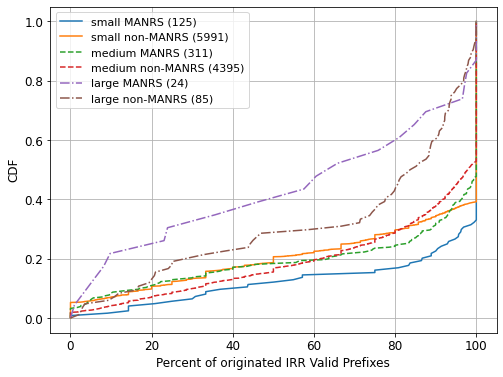

In [52]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(small_manrs_origin_irr)), label='small MANRS ({})'.format(len(small_manrs_origin_irr)), linestyle='-')
plt.plot(np.sort(small_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(small_non_manrs_origin_irr)), label='small non-MANRS ({})'.format(len(small_non_manrs_origin_irr)), linestyle='-')
plt.plot(np.sort(medium_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(medium_manrs_origin_irr)), label='medium MANRS ({})'.format(len(medium_manrs_origin_irr)), linestyle='--')
plt.plot(np.sort(medium_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(medium_non_manrs_origin_irr)), label='medium non-MANRS ({})'.format(len(medium_non_manrs_origin_irr)), linestyle='--')
plt.plot(np.sort(large_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(large_manrs_origin_irr)), label='large MANRS ({})'.format(len(large_manrs_origin_irr)), linestyle='-.')
plt.plot(np.sort(large_non_manrs_origin_irr['valid_percent']), np.linspace(0,1,len(large_non_manrs_origin_irr)), label='large non-MANRS ({})'.format(len(large_non_manrs_origin_irr)), linestyle='-.')
plt.xlabel('Percent of originated IRR Valid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':11})
plt.grid()

## MANRS ASes that register only in IRR but not in RPKI

In [53]:
small_manrs_irr_only = small_manrs_origin_irr[['originasn_id','irr_percent']].merge(small_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
small_non_manrs_irr_only = small_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(small_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


medium_manrs_irr_only = medium_manrs_origin_irr[['originasn_id','irr_percent']].merge(medium_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
medium_non_manrs_irr_only = medium_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(medium_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


large_manrs_irr_only = large_manrs_origin_irr[['originasn_id','irr_percent']].merge(large_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])
large_non_manrs_irr_only = large_non_manrs_origin_irr[['originasn_id','irr_percent']].merge(large_non_manrs_origin_rpki[['originasn_id','rpki_percent','valid_percent']])


In [54]:
small_manrs_irr_only[(small_manrs_irr_only.irr_percent > 0) & (small_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
6,5503,100.000000,0.0,0.0
7,6509,100.000000,0.0,0.0
13,11650,100.000000,0.0,0.0
16,14361,98.765432,0.0,0.0
19,16094,100.000000,0.0,0.0
23,23028,100.000000,0.0,0.0
27,26134,100.000000,0.0,0.0
34,28154,100.000000,0.0,0.0
44,34225,100.000000,0.0,0.0
46,35457,100.000000,0.0,0.0


In [55]:
medium_manrs_irr_only[(medium_manrs_irr_only.irr_percent > 0) & (medium_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent
3,271,100.000000,0.0,0.0
4,293,100.000000,0.0,0.0
7,557,100.000000,0.0,0.0
22,2572,100.000000,0.0,0.0
34,4538,99.930955,0.0,0.0
48,7342,100.000000,0.0,0.0
56,7850,100.000000,0.0,0.0
75,10886,100.000000,0.0,0.0
84,11714,100.000000,0.0,0.0
98,14041,100.000000,0.0,0.0


In [56]:
large_manrs_irr_only[(large_manrs_irr_only.irr_percent > 0) & (large_manrs_irr_only.rpki_percent == 0)]

,originasn_id,irr_percent,rpki_percent,valid_percent


# **MANRS Action 4 Conformance**
Conformance analysis is separate for ASes in the MANRS Network Operators Program and MANRS CDN Program

In [57]:
def irr_or_rpki(r):
    if r['irr_status'] == 'Valid' or r['rpki_status'] == 'Valid' or r['irr_status'] == 'Invalid,more-specific':
        return True
    return False

In [ ]:
manrs_origin['either_status'] = manrs_origin.apply(irr_or_rpki, axis=1)

In [ ]:
non_manrs_origin['either_status'] = non_manrs_origin.apply(irr_or_rpki, axis=1)

In [ ]:
manrs_origin_either = manrs_origin.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

In [ ]:
non_manrs_origin_either = non_manrs_origin.groupby(['originasn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

## Terminology: Explanation of column names
`either_status`: Index of each row  
`originasn_id`: A MANRS AS  
`False`: Number of prefixes announced by the `originasn_id` that is neither RPKI valid nor IRR valid. MANRS ASes that announce such prefixes maybe non-conformant.  
`True`: Number of prefixes announnced by the `originasn_id` that is either RPKI valid or IRR valid

In [ ]:
manrs_origin_either[manrs_origin_either[False] > 0]

In [ ]:
manrs_origin_either['valid_percent'] = manrs_origin_either[True]/(manrs_origin_either[False] + manrs_origin_either[True])*100

In [ ]:
manrs_origin_either['company'] = manrs_origin_either['originasn_id'].apply(lambda x: manrs_org[x])

In [ ]:
non_manrs_origin_either['valid_percent'] = non_manrs_origin_either[True]/(non_manrs_origin_either[False] + non_manrs_origin_either[True])*100

In [ ]:
small_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(small)]
medium_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(medium)]
large_manrs_origin_either = manrs_origin_either[manrs_origin_either.originasn_id.isin(large)]
small_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(small)]
medium_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(medium)]
large_non_manrs_origin_either = non_manrs_origin_either[non_manrs_origin_either.originasn_id.isin(large)]

## **Non-conformant MANRS ASes in the Network Operators Program**

An AS is non-conformant if it announces less than **90%** prefixes that are either RPKI valid or IRR valid

In [ ]:
small_manrs_origin_either[(small_manrs_origin_either.originasn_id.isin(manrs)) & (small_manrs_origin_either.valid_percent < 90)]


In [ ]:
medium_manrs_origin_either[(medium_manrs_origin_either.originasn_id.isin(manrs)) & (medium_manrs_origin_either.valid_percent < 90)]


In [ ]:
large_manrs_origin_either[(large_manrs_origin_either.originasn_id.isin(manrs)) & (large_manrs_origin_either.valid_percent < 90)]


In [ ]:
len(manrs)

## **Non-conformant MANRS ASes in the Network Operators Program**

An AS is non-conformant if it announces less than **100%** prefixes that are either RPKI valid or IRR valid

In [ ]:
small_manrs_origin_either[(small_manrs_origin_either.originasn_id.isin(manrscdn)) & (small_manrs_origin_either.valid_percent < 100)]


In [ ]:
medium_manrs_origin_either[(medium_manrs_origin_either.originasn_id.isin(manrscdn)) & (medium_manrs_origin_either.valid_percent < 100)]

In [ ]:
large_manrs_origin_either[(large_manrs_origin_either.originasn_id.isin(manrscdn)) & (large_manrs_origin_either.valid_percent < 100)]

## Case studies

In Table 1 in the paper, ISP1-3 and CDN1-3 are the companies:

### ISP1: comcast case

In [ ]:
comcast = manrs_origin_either[manrs_origin_either.org == 'Comcast']

In [ ]:
manrs_origin[manrs_origin.prefix == '104.243.67.0/24']

In [ ]:
comcast[comcast.valid_percent < 90]

In [ ]:
manrs_origin[manrs_origin.originasn_id.isin(comcast.originasn_id)].groupby(['originasn_id', 'irr_status', 'rpki_status']).size().unstack(fill_value=0)

### CDN1: akamai case

In [ ]:
akamai = manrs_origin_either[manrs_origin_either.org == 'Akamai Technologies']

In [ ]:
akamai

In [ ]:
manrs_origin[(manrs_origin.originasn_id == 20940) & (manrs_origin.rpki_status.str.contains('Invalid'))]

In [ ]:
non_manrs_origin[non_manrs_origin.originasn_id==34164].groupby(['originasn_id', 'rpki_status', 'irr_status']).size().unstack(fill_value=0)

### CDN2: amazon case

In [ ]:
amazon = manrs_origin_either[manrs_origin_either.org == 'Amazon Web Services']

In [ ]:
manrs_origin[manrs_origin.originasn_id.isin(amazon.originasn_id)]

In [ ]:
manrs_origin[(manrs_origin.originasn_id == 16509) & (manrs_origin.rpki_status.str.contains('Invalid'))]

### CDN3: vultr case

In [ ]:
vultr = manrs_origin_either[manrs_origin_either.org == 'Vultr']

In [ ]:
manrs_origin[manrs_origin.originasn_id.isin(vultr.originasn_id)]

In [ ]:
manrs_origin[(manrs_origin.originasn_id == 20473) & (manrs_origin.rpki_status.str.contains('Invalid'))]

### ISP3: level3 case

In [ ]:
level3 = manrs_origin_either[manrs_origin_either.org == 'CenturyLink']

### ISP2: cogent case

In [ ]:
cogent = manrs_origin_either[manrs_origin_either.org == 'Cogent Communications Inc.']